In [5]:
# ==========================================
# 0. 라이브러리 import
# ==========================================
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score, classification_report

from xgboost import XGBClassifier
import optuna


/home/kdt_43/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
df = pd.read_csv("stroke.csv")

In [7]:
# ==========================================
# 1. 데이터 준비 (df가 이미 있다고 가정)
# ==========================================
target_col = "stroke"  # <- 타깃 컬럼명 확인

X = df.drop(columns=[target_col])
y = df[target_col]


In [8]:
# ==========================================
# 2. Train/Test Split (stratify로 클래스 비율 유지)
# ==========================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [9]:
# ==========================================
# 3. SMOTE 대신 scale_pos_weight 계산 (불균형 가중치)
#    - pos_ratio: 양성(1) 비율
#    - scale_pos_weight = (음성/양성)
# ==========================================
pos_ratio = y_train.sum() / len(y_train)
scale_pos = (1 - pos_ratio) / pos_ratio

print(f"양성(1) 비율: {pos_ratio:.4f}")
print(f"scale_pos_weight: {scale_pos:.4f}")


양성(1) 비율: 0.0487
scale_pos_weight: 19.5427


In [10]:
# ==========================================
# 4. Optuna 목적함수 정의 (가중치 기반 XGBoost + AUC CV)
#    - SMOTE 없음 (원본 분포 유지)
#    - StratifiedKFold로 CV에서도 클래스 비율 유지
# ==========================================
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

def objective(trial):

    params = {
        # 모델이 학습하는 속도(작을수록 천천히 안정적으로)
        "learning_rate": trial.suggest_float("lr", 0.01, 0.1),

        # 트리의 복잡도(깊이)
        "max_depth": trial.suggest_int("max_depth", 3, 6),

        # 트리 개수
        "n_estimators": trial.suggest_int("n_estimators", 300, 900),

        # 일부 데이터만 사용해 과적합 줄이기
        "subsample": trial.suggest_float("subsample", 0.6, 0.9),

        # 일부 변수만 사용해 특정 변수 쏠림 방지
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 0.9),

        # 너무 작은 그룹으로 split 하지 않도록(과적합 방지)
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 5),

        # 의미 있는 경우에만 split(잡음 감소)
        "gamma": trial.suggest_float("gamma", 0, 1),

        # ✅ SMOTE 대신 가중치로 불균형 처리
        "scale_pos_weight": scale_pos,

        # 평가 지표
        "eval_metric": "auc",

        # 재현성/속도
        "random_state": 42,
        "n_jobs": -1,

        # (GPU 쓰는 환경이면 켜기)
        "tree_method": "gpu_hist",
        "predictor": "gpu_predictor",
    }

    model = XGBClassifier(**params)

    auc = cross_val_score(
        model,
        X_train,
        y_train,
        cv=cv,
        scoring="roc_auc"
    ).mean()

    return auc


In [8]:
# ==========================================
# 5. Optuna 실행
# ==========================================
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best params:", study.best_params)
print("Best AUC:", study.best_value)


[I 2025-12-18 11:16:52,795] A new study created in memory with name: no-name-d88ffa88-c6f4-49da-80c4-a221eb20716e
/home/kdt_43/miniconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:16:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/kdt_43/miniconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:16:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/home/kdt_43/miniconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:16:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warning

KeyboardInterrupt: 

In [13]:
# 최적 파라미터(Optuna 결과)
best_params = {
    "learning_rate": 0.010002154204346032,
    "max_depth": 4,
    "n_estimators": 537,
    "subsample": 0.6055566573624598,
    "colsample_bytree": 0.8979287201002785,
    "min_child_weight": 5,
    "gamma": 0.7209404101015859,
}

In [19]:
# ==========================================
# 6. Best params로 최종 모델 학습 (Train 전체로 fit)
#    - Optuna에서 "lr" 이름으로 뽑았으니, XGBoost 파라미터명으로 변환 필요
# ==========================================
# best_params = study.best_params.copy()
# best_params["learning_rate"] = best_params.pop("lr")  # lr -> learning_rate

# Optuna 탐색에 없었던 고정값들 추가
best_params.update({
    "scale_pos_weight": scale_pos,
    "eval_metric": "auc",
    "random_state": 42,
    "n_jobs": -1,
    "tree_method": "gpu_hist",
    "predictor": "gpu_predictor",
})

final_model = XGBClassifier(**best_params)
final_model.fit(X_train, y_train)


/home/kdt_43/miniconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:02:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/kdt_43/miniconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:02:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8979287201002785, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_types=None, gamma=0.7209404101015859,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.010002154204346032,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=537, n_jobs=-1,
              num_parallel_tree=None, predictor='gpu_predictor', ...)

In [34]:
# ==========================================
# 7. Test 평가 (ROC-AUC + 기본 threshold 성능)
# ==========================================
y_proba = final_model.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_proba)

print(f"✅ Test ROC-AUC: {test_auc:.4f}")

# threshold=0.5는 참고용
y_pred = (y_proba >= 0.4).astype(int)
print(classification_report(y_test, y_pred, digits=3))


✅ Test ROC-AUC: 0.8415
              precision    recall  f1-score   support

           0      0.987     0.727     0.838       972
           1      0.134     0.820     0.230        50

    accuracy                          0.732      1022
   macro avg      0.561     0.774     0.534      1022
weighted avg      0.946     0.732     0.808      1022



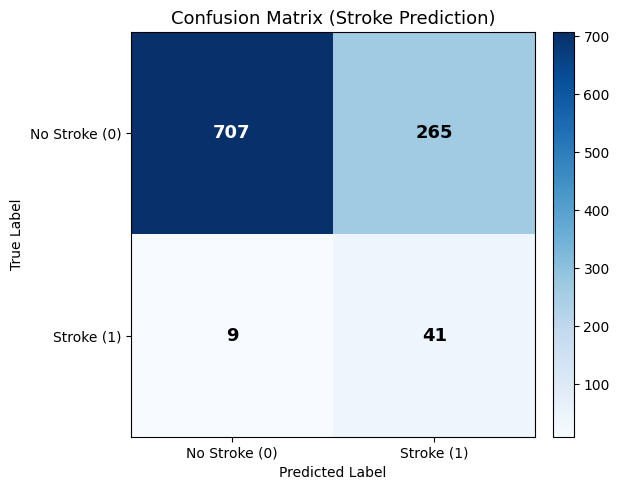

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# ------------------------------------------
# 1. 예측 확률 & 예측 클래스
# ------------------------------------------
y_proba = final_model.predict_proba(X_test)[:, 1]

threshold = 0.4  # 네가 쓰던 threshold
y_pred = (y_proba >= threshold).astype(int)

# ------------------------------------------
# 2. Confusion Matrix 계산
# ------------------------------------------
cm = confusion_matrix(y_test, y_pred)

# ------------------------------------------
# 3. 시각화 (예쁜 블루 + 가독성 강화)
# ------------------------------------------
plt.figure(figsize=(6, 5))
plt.imshow(cm, cmap="Blues")  # 👈 핵심: 색깔 수정
plt.title("Confusion Matrix (Stroke Prediction)", fontsize=13)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.xticks([0, 1], ["No Stroke (0)", "Stroke (1)"])
plt.yticks([0, 1], ["No Stroke (0)", "Stroke (1)"])

# 숫자 표시 (배경 진하면 흰색, 연하면 검정)
max_val = cm.max()
for i in range(2):
    for j in range(2):
        text_color = "white" if cm[i, j] > max_val / 2 else "black"
        plt.text(
            j, i, cm[i, j],
            ha="center", va="center",
            fontsize=13, fontweight="bold",
            color=text_color
        )

plt.colorbar(fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()


---

# 통계 분석 시각화

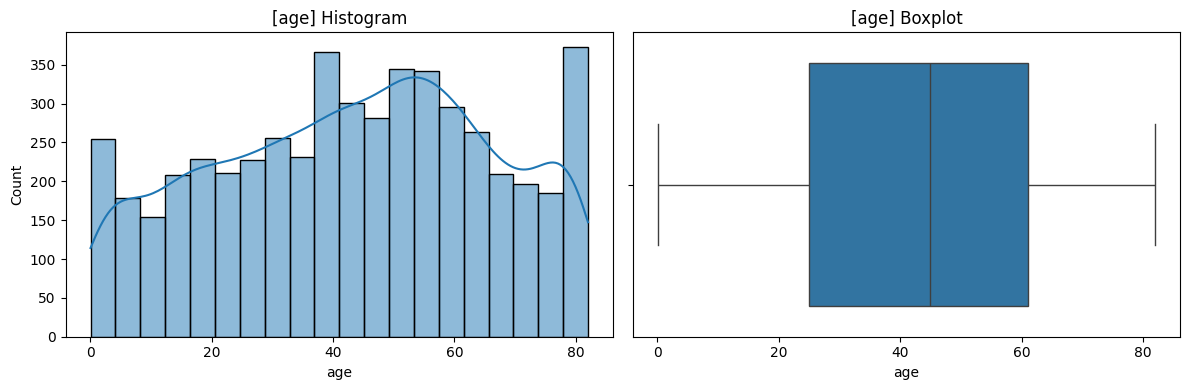

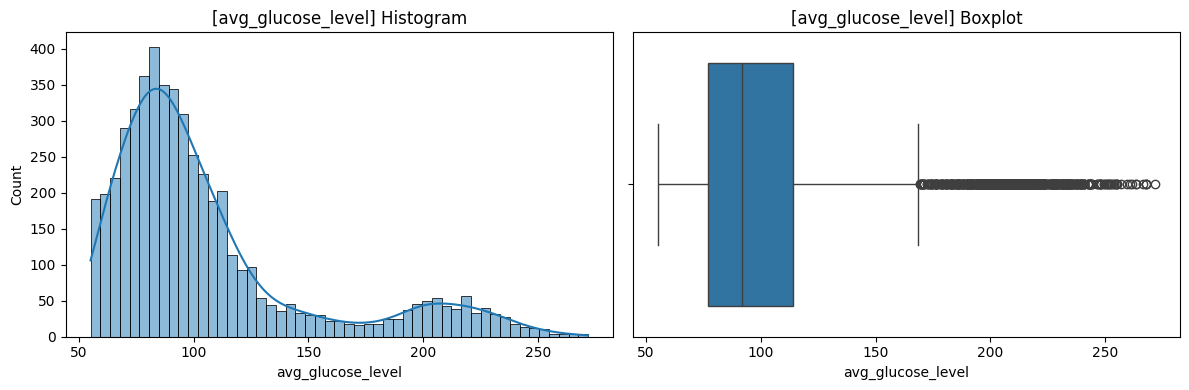

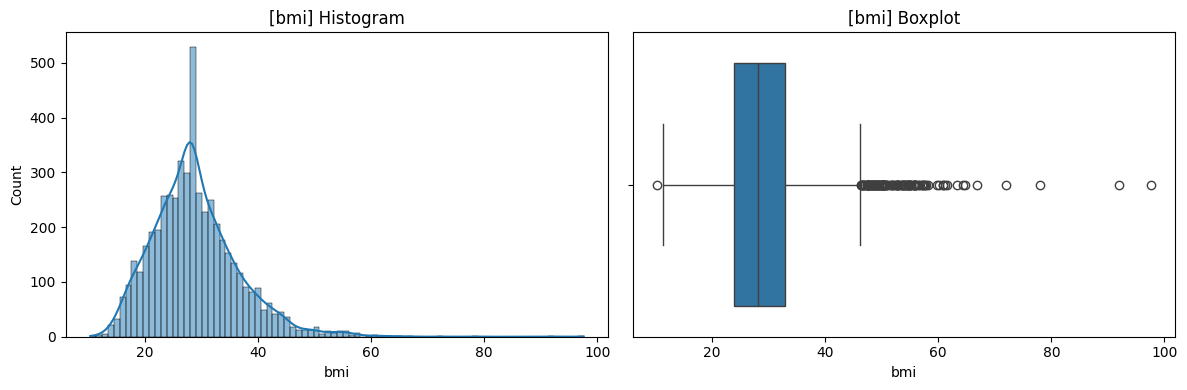

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 4-0 숫자형 변수 목록
num_cols = ["age", "avg_glucose_level", "bmi"]

# 4-0 범주형 변수 목록
cat_cols = ["gender", "hypertension", "heart_disease", 
            "ever_married", "work_type", "Residence_type", 
            "smoking_status"]

# 4-2 숫자형 변수: 히스토그램 / 박스플롯
for col in num_cols:
    plt.figure(figsize=(12,4))
    
    # 히스토그램
    plt.subplot(1, 2, 1)
    sns.histplot(df[col], kde=True)
    plt.title(f"[{col}] Histogram")  # 분포 전체 형태 파악하기 좋음
    
    # 박스플롯
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[col])
    plt.title(f"[{col}] Boxplot")    # 이상치(outlier) 확인하기 좋음
    
    plt.tight_layout()
    plt.show()

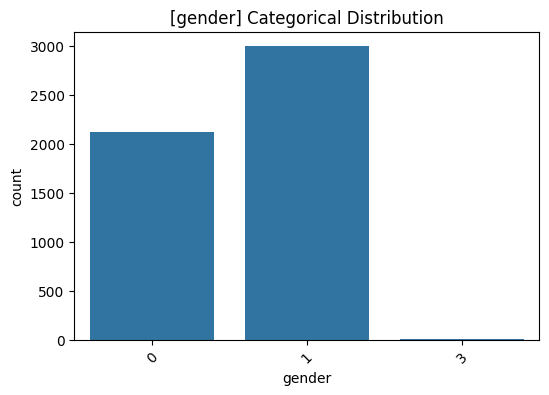

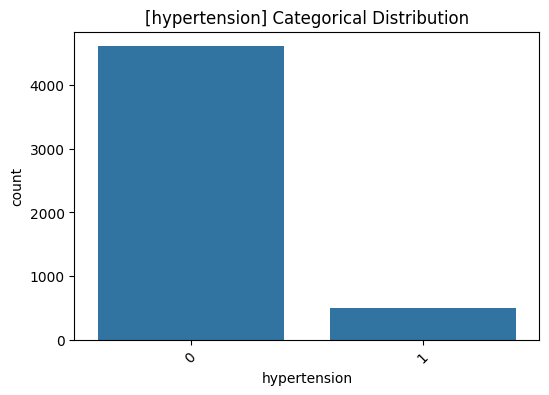

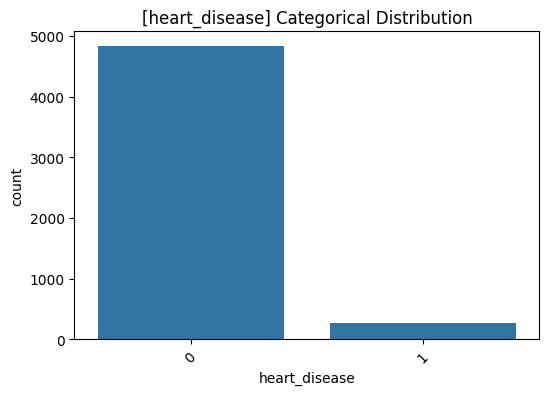

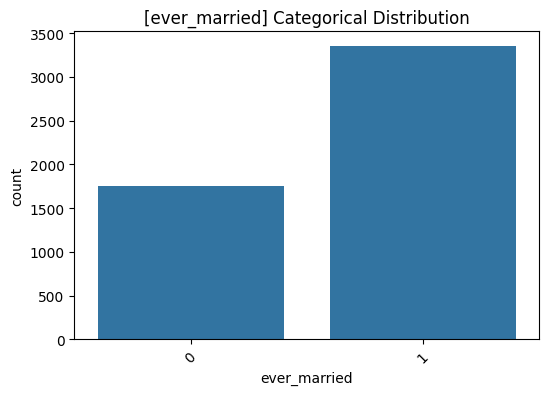

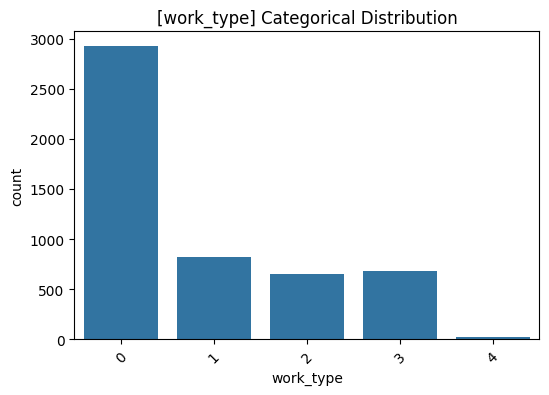

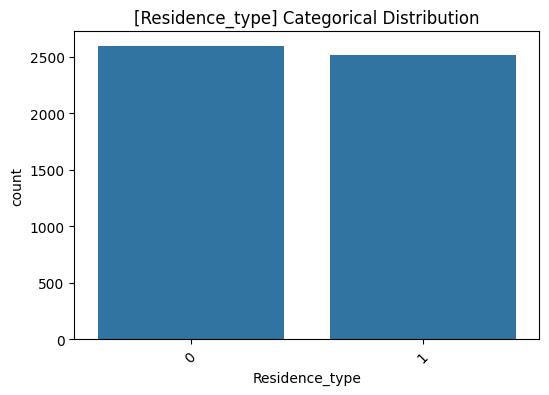

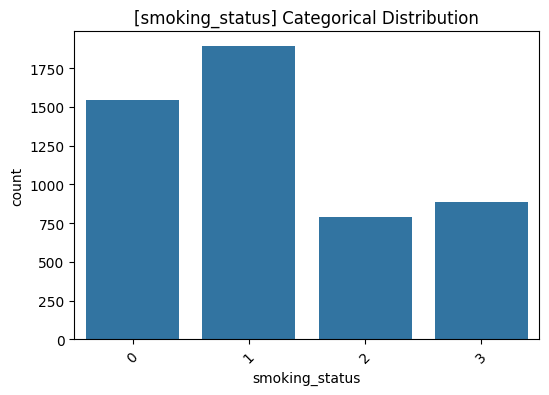

In [18]:
# 4-4 범주형 변수: 막대그래프
for col in cat_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(x=df[col])
    plt.title(f"[{col}] Categorical Distribution")
    plt.xticks(rotation=45)  # 범주명이 길 때 보기 좋게
    plt.show()


✅ stroke 그룹별 숫자형 변수 기초 통계
stroke                             0           1
age               count  4861.000000  249.000000
                  mean     41.971545   67.728193
                  std      22.291940   12.727419
                  min       0.080000    1.320000
                  25%      24.000000   59.000000
                  50%      43.000000   71.000000
                  75%      59.000000   78.000000
                  max      82.000000   82.000000
avg_glucose_level count  4861.000000  249.000000
                  mean    104.795513  132.544739
                  std      43.846069   61.921056
                  min      55.120000   56.110000
                  25%      77.120000   79.790000
                  50%      91.470000  105.220000
                  75%     112.830000  196.710000
                  max     267.760000  271.740000
bmi               count  4861.000000  249.000000
                  mean     28.799115   30.090361
                  std       7.777269    5.8

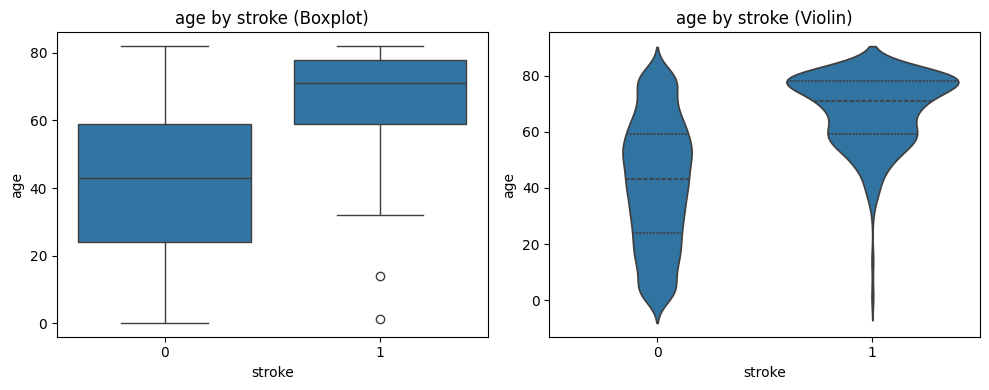

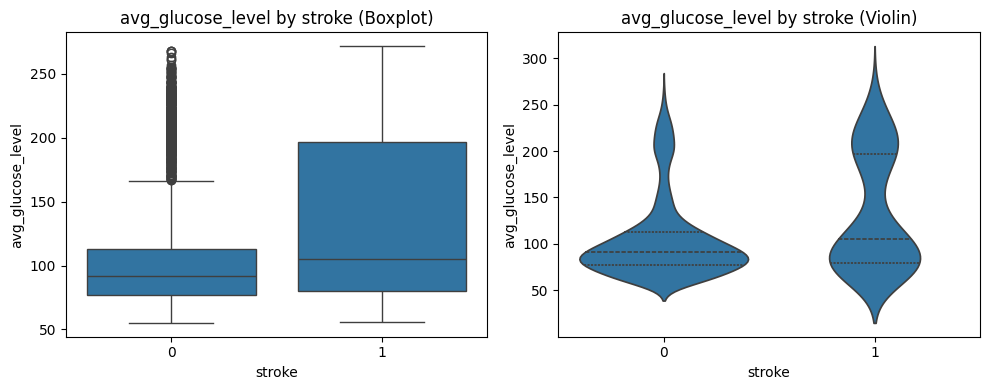

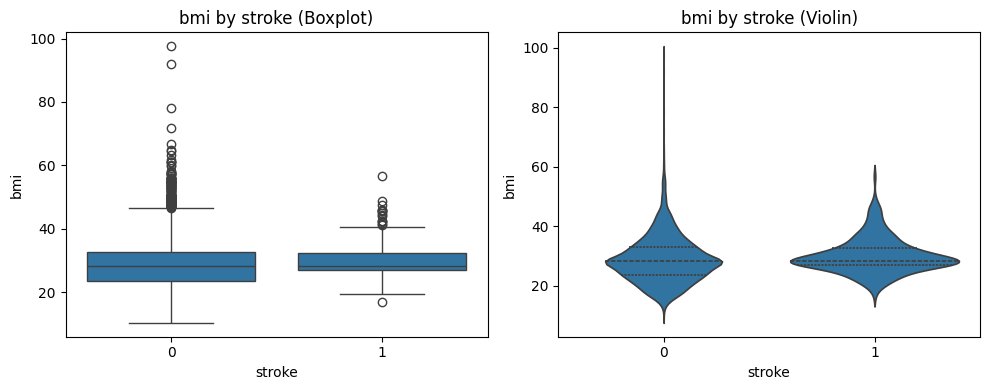

In [19]:
# 6. stroke=0 vs 1 에서 숫자형 변수 분포 비교
#    (기초 통계 + 박스/바이올린 플롯)
print("✅ stroke 그룹별 숫자형 변수 기초 통계")
group_stats = df.groupby("stroke")[num_cols].describe().T
print(group_stats, "\n")

# 박스/바이올린 플롯으로 분포 비교
for col in num_cols:
    plt.figure(figsize=(10,4))

    # 박스플롯: 중앙값, IQR 비교
    plt.subplot(1, 2, 1)
    sns.boxplot(x="stroke", y=col, data=df)
    plt.title(f"{col} by stroke (Boxplot)")

    # 바이올린 플롯: 분포 모양 비교
    plt.subplot(1, 2, 2)
    sns.violinplot(x="stroke", y=col, data=df, inner="quartile")
    plt.title(f"{col} by stroke (Violin)")

    plt.tight_layout()
    plt.show()

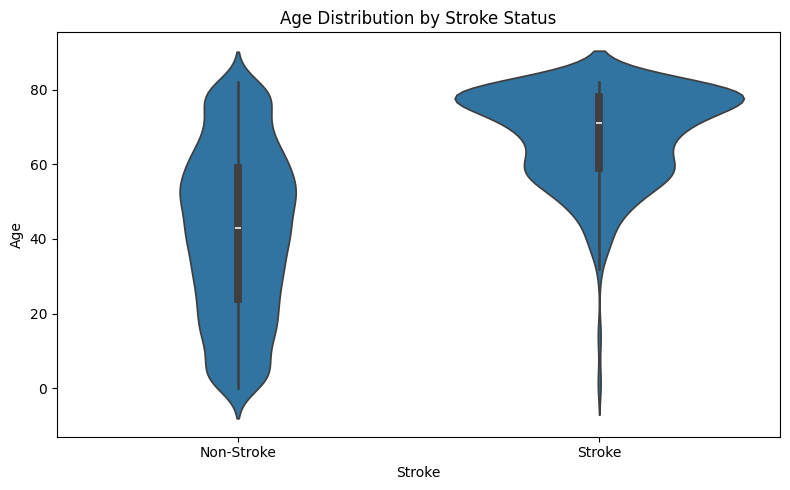

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.violinplot(x="stroke", y="age", data=df, inner="box")
plt.xticks([0,1], ["Non-Stroke", "Stroke"])
plt.title("Age Distribution by Stroke Status")
plt.xlabel("Stroke")
plt.ylabel("Age")
plt.tight_layout()
plt.show()


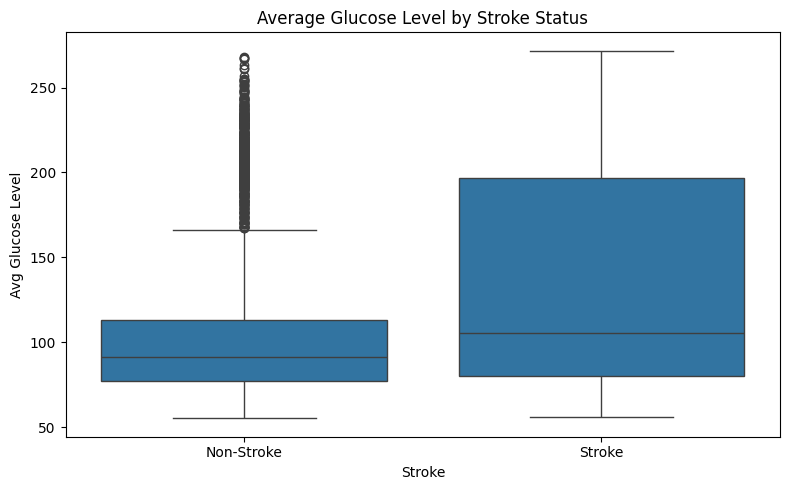

In [22]:
plt.figure(figsize=(8,5))
sns.boxplot(x="stroke", y="avg_glucose_level", data=df)
plt.xticks([0,1], ["Non-Stroke", "Stroke"])
plt.title("Average Glucose Level by Stroke Status")
plt.xlabel("Stroke")
plt.ylabel("Avg Glucose Level")
plt.tight_layout()
plt.show()


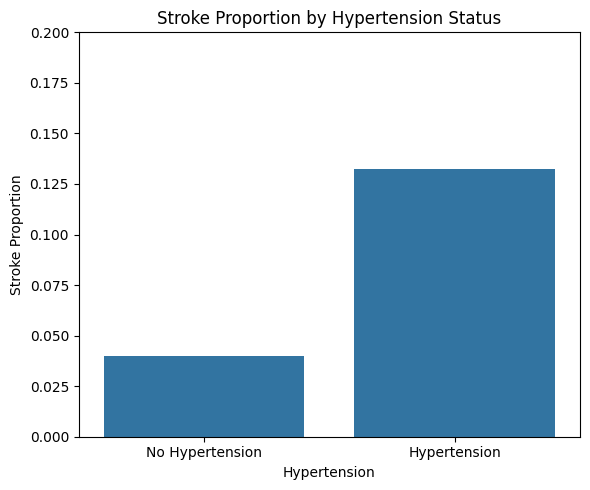

In [21]:
# 고혈압별 stroke 비율 계산
ht_rate = (
    df.groupby("hypertension")["stroke"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(6,5))
sns.barplot(x="hypertension", y="stroke", data=ht_rate)
plt.xticks([0,1], ["No Hypertension", "Hypertension"])
plt.ylabel("Stroke Proportion")
plt.xlabel("Hypertension")
plt.title("Stroke Proportion by Hypertension Status")
plt.ylim(0, 0.2)
plt.tight_layout()
plt.show()


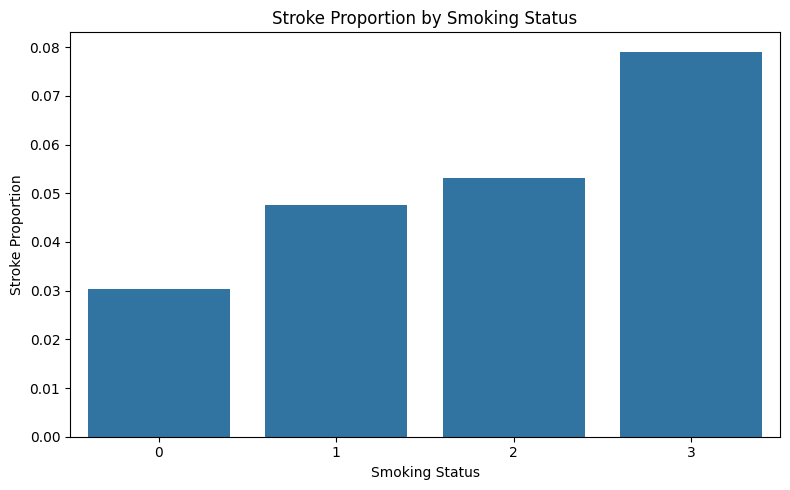

In [23]:
smoke_rate = (
    df.groupby("smoking_status")["stroke"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(8,5))
sns.barplot(x="smoking_status", y="stroke", data=smoke_rate)
plt.xlabel("Smoking Status")
plt.ylabel("Stroke Proportion")
plt.title("Stroke Proportion by Smoking Status")
plt.tight_layout()
plt.show()


# 모델 시각화

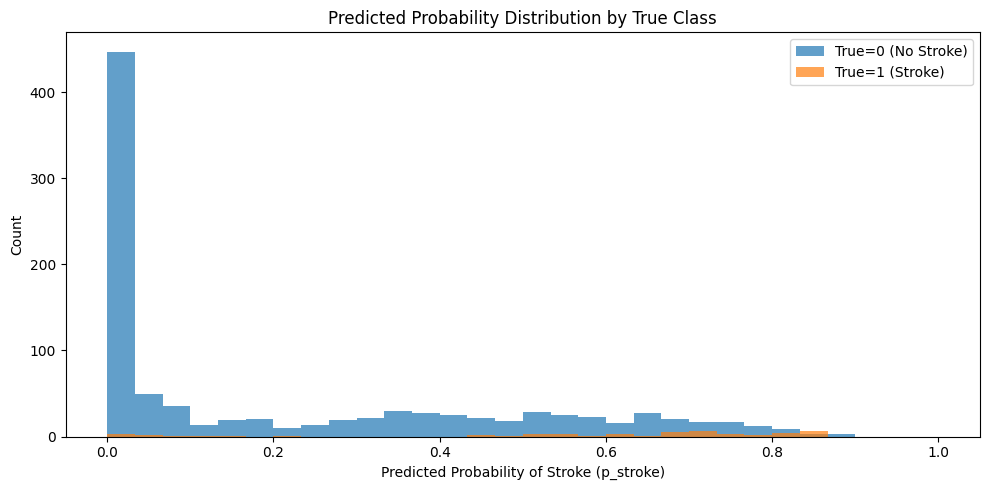

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 0) 예측 확률 만들기 (final_model, X_test, y_test가 이미 있어야 함)
y_proba = final_model.predict_proba(X_test)[:, 1]
y_true = np.asarray(y_test).astype(int)

res = pd.DataFrame({"y_true": y_true, "p_stroke": y_proba})

# 1) 예측 확률 분포 비교
plt.figure(figsize=(10, 5))
bins = np.linspace(0, 1, 31)

plt.hist(res.loc[res["y_true"] == 0, "p_stroke"], bins=bins, alpha=0.7, label="True=0 (No Stroke)")
plt.hist(res.loc[res["y_true"] == 1, "p_stroke"], bins=bins, alpha=0.7, label="True=1 (Stroke)")

plt.xlabel("Predicted Probability of Stroke (p_stroke)")
plt.ylabel("Count")
plt.title("Predicted Probability Distribution by True Class")
plt.legend()
plt.tight_layout()
plt.show()


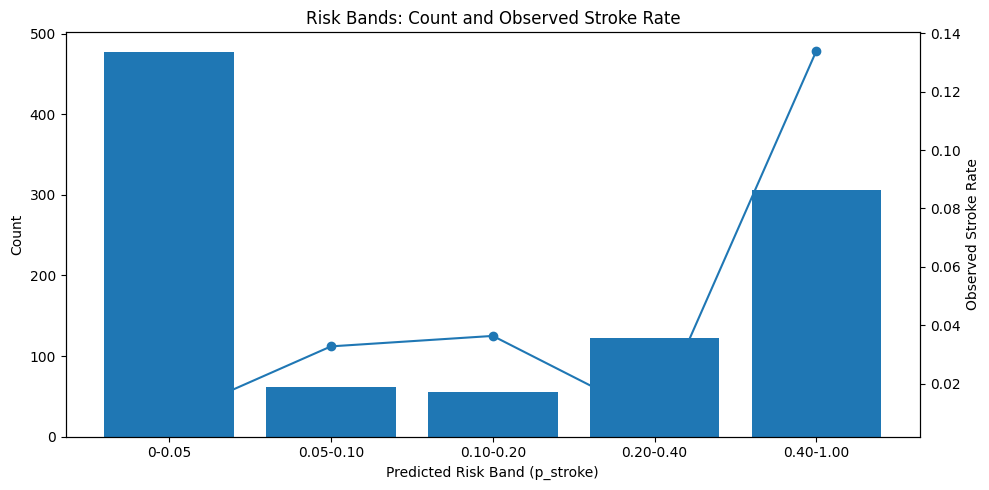

,risk_band,count,observed_rate
0,0-0.05,478,0.008368
1,0.05-0.10,61,0.032787
2,0.10-0.20,55,0.036364
3,0.20-0.40,122,0.008197
4,0.40-1.00,306,0.133987


In [30]:
import pandas as pd
import matplotlib.pyplot as plt

# (이미 위에서 res 만들었다고 가정)
# res = pd.DataFrame({"y_true": y_true, "p_stroke": y_proba})

# 리스크 밴드(원하면 경계값 바꿔도 됨)
bins = [0.0, 0.05, 0.10, 0.20, 0.40, 1.0]
labels = ["0-0.05", "0.05-0.10", "0.10-0.20", "0.20-0.40", "0.40-1.00"]
res["risk_band"] = pd.cut(res["p_stroke"], bins=bins, labels=labels, include_lowest=True)

band = (
    res.groupby("risk_band", observed=True)
       .agg(count=("y_true", "size"), observed_rate=("y_true", "mean"))
       .reset_index()
)

fig, ax1 = plt.subplots(figsize=(10, 5))

# 사람 수(막대)
ax1.bar(band["risk_band"].astype(str), band["count"])
ax1.set_xlabel("Predicted Risk Band (p_stroke)")
ax1.set_ylabel("Count")

# 실제 발생률(선)
ax2 = ax1.twinx()
ax2.plot(band["risk_band"].astype(str), band["observed_rate"], marker="o")
ax2.set_ylabel("Observed Stroke Rate")

plt.title("Risk Bands: Count and Observed Stroke Rate")
plt.tight_layout()
plt.show()

# (선택) 표로도 확인
band


In [33]:
import numpy as np
import pandas as pd

# 예측 확률
y_proba = final_model.predict_proba(X_test)[:, 1]

# 결과 테이블
res = pd.DataFrame({
    "p_stroke": y_proba,
    "y_true": np.asarray(y_test).astype(int)
}, index=X_test.index)

# (있으면 같이 보여줄 대표 feature들) - 없으면 자동으로 빼고 진행됨
candidate_cols = ["age", "gender", "hypertension", "heart_disease", "avg_glucose_level", "bmi", "smoking_status"]
existing_cols = [c for c in candidate_cols if c in X_test.columns]

# Top 20 고위험 샘플
top20 = res.sort_values("p_stroke", ascending=False).head(250).copy()

# feature 붙이기(가능한 경우에만)
if existing_cols:
    top20 = top20.join(X_test.loc[top20.index, existing_cols])

# 보기 좋게 출력
top20_display = top20.reset_index().rename(columns={"index": "sample_id"})
top20_display


,sample_id,p_stroke,y_true,age,gender,hypertension,heart_disease,avg_glucose_level,bmi,smoking_status
0,2524,0.895820,0,81.0,0,0,0,165.47,28.1,0
1,3318,0.882755,0,81.0,0,1,1,220.64,30.0,1
2,4724,0.881502,0,81.0,1,1,0,174.54,26.4,1
3,1184,0.866176,0,79.0,1,0,0,65.59,28.1,1
4,3625,0.865173,0,78.0,0,0,1,206.62,28.0,3
...,...,...,...,...,...,...,...,...,...,...
245,1524,0.488275,0,62.0,0,0,0,121.27,29.7,2
246,222,0.486827,1,63.0,1,0,0,205.35,42.2,3
247,3597,0.486008,0,64.0,1,0,0,77.68,31.4,1
248,4966,0.484687,0,54.0,0,0,0,111.37,29.1,3


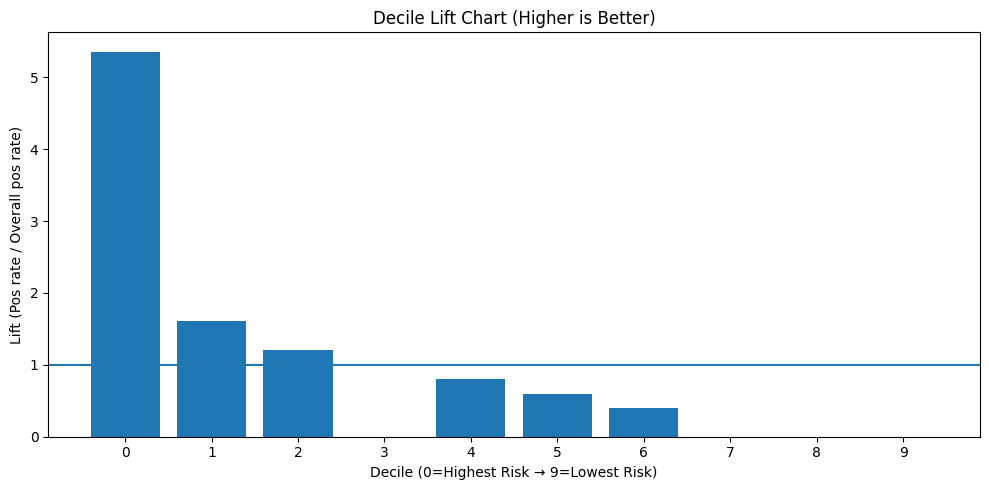

,decile,count,positives,pos_rate,lift
0,0,103,27,0.262136,5.358058
1,1,102,8,0.078431,1.603137
2,2,102,6,0.058824,1.202353
3,3,102,0,0.000000,0.000000
4,4,102,4,0.039216,0.801569
5,5,102,3,0.029412,0.601176
6,6,102,2,0.019608,0.400784
7,7,102,0,0.000000,0.000000
8,8,102,0,0.000000,0.000000
9,9,103,0,0.000000,0.000000


In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 예측 확률
y_proba = final_model.predict_proba(X_test)[:, 1]
y_true = np.asarray(y_test).astype(int)

df_lift = pd.DataFrame({"p_stroke": y_proba, "y_true": y_true})

# 예측확률 기준으로 10분위(상위가 1 decile이 되도록)
df_lift["decile"] = pd.qcut(df_lift["p_stroke"], 10, labels=False, duplicates="drop")
df_lift["decile"] = 9 - df_lift["decile"]  # 9(가장 높음) → 0(가장 낮음) 이라서 뒤집기

# 분위별 통계
overall_rate = df_lift["y_true"].mean()

summary = (df_lift.groupby("decile")
           .agg(count=("y_true", "size"),
                positives=("y_true", "sum"),
                pos_rate=("y_true", "mean"))
           .sort_index()
           .reset_index())

# Lift = (해당 분위의 양성비율) / (전체 양성비율)
summary["lift"] = summary["pos_rate"] / (overall_rate + 1e-12)

# Lift Chart
plt.figure(figsize=(10, 5))
plt.bar(summary["decile"].astype(str), summary["lift"])
plt.axhline(1.0)  # lift=1은 “랜덤과 동일”
plt.xlabel("Decile (0=Highest Risk → 9=Lowest Risk)")
plt.ylabel("Lift (Pos rate / Overall pos rate)")
plt.title("Decile Lift Chart (Higher is Better)")
plt.tight_layout()
plt.show()

# (선택) 표도 같이 보기
summary
